In [1]:
import warnings
warnings.filterwarnings('ignore')

import random
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]

import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image

from art.estimators.classification import TensorFlowV2Classifier, EnsembleClassifier
from art.attacks.evasion import AdversarialPatch
import sys
sys.path.append('../lib')
import utils
from utils import load_preprocess, show_adversarial_images

2024-06-11 22:44:54.147477: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-11 22:44:54.147505: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-11 22:44:54.148434: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
image_shape = (224, 224, 3)
clip_values = (0, 255)
batch_size = 16
scale_min = 0.4
scale_max = 1.0
rotation_max = 22.5
learning_rate = 5000.
max_iter = 500

In [4]:
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
model = ResNet50V2(weights="imagenet")

mean_b = 103.939
mean_g = 116.779
mean_r = 123.680

wrapper = TensorFlowV2Classifier(model=model, loss_object=None, train_step=None, 
                             input_shape=(224, 224, 3), clip_values=(0, 255), nb_classes=1000,
                             preprocessing=([mean_b, mean_g, mean_r], np.array([1.0, 1.0, 1.0])))

In [5]:
ap = AdversarialPatch(classifier=wrapper, rotation_max=22.5, scale_min=0.4, scale_max=scale_max,
                      learning_rate=learning_rate, max_iter=500, batch_size=16,
                      patch_shape=(224, 224, 3))

# load sample image to attack 
img = load_preprocess('../images/racing-car.jpg')
# set the target to a tabby cat 
target_class = 281  # 'tabby cat' class in ImageNet
y_one_hot = np.zeros(1000)
y_one_hot[target_class] = 1.0
y_target = np.expand_dims(y_one_hot, axis=0)  # Shape (1, 1000)
#generate the patch
patch, _ = ap.generate(x=img, y=y_target)

Adversarial Patch TensorFlow v2:   0%|          | 0/500 [00:00<?, ?it/s]

I0000 00:00:1718142313.522512  772206 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [6]:
patched_image = ap.apply_patch(img, scale=0.5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


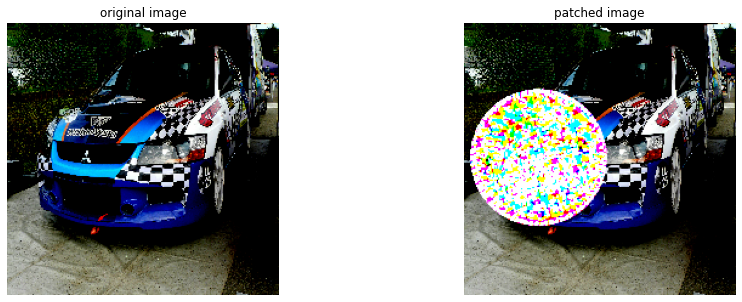

In [9]:
utils.show_images([img[0], patched_image[0]],['original image','patched image'])

In [8]:
# Classify the original and patched images
def classify_image(img):
    preds = model.predict(img)
    return decode_predictions(preds, top=3)[0]

# Classify and display the results
original_preds = classify_image(img)
patched_preds = classify_image(patched_image)

print("Original Image Predictions:")
for pred in original_preds:
    print(f"{pred[1]}: {pred[2]*100:.2f}%")

print("\nPatched Image Predictions:")
for pred in patched_preds:
    print(f"{pred[1]}: {pred[2]*100:.2f}%")

1/1 [==============================] - 0s 15ms/step
Original Image Predictions:
racer: 73.30%
sports_car: 14.27%
minivan: 4.29%

Patched Image Predictions:
fox_squirrel: 99.98%
airliner: 0.02%
bulbul: 0.00%
